In [2]:
import xarray as xr, matplotlib.pyplot as plt, cartopy, pandas as pd, numpy as np, regionmask

from dateutil.relativedelta import relativedelta
from datetime import datetime, timedelta

mapproj = cartopy.crs.PlateCarree()

def main_polygon(gdf):
    gdf = gdf.dissolve().explode(index_parts = False)
    gdf = gdf.loc[gdf.geometry.area == gdf.geometry.area.max()]
    return gdf

def decode_times(ts):
    
    # Method to manually decode times
    
    inc = re.sub(" .+", "", ts.time.units)
    startdate = pd.Timestamp(re.sub(".+since ", "", ts.time.units)+' 00:00:00.000000').to_pydatetime()
    
    if inc == "years":
        new_times = [np.datetime64(startdate + relativedelta(years = i)) for i in ts.time.values]
    elif inc == "months":
        new_times = [np.datetime64(startdate + relativedelta(months = i)) for i in ts.time.values]
    elif inc == "days":
        new_times = [np.datetime64(startdate + relativedelta(days = i)) for i in ts.time.values]
    elif inc == "hours":
        new_times = [np.datetime64(startdate + relativedelta(hours = i)) for i in ts.time.values]
    else:
        print("TBD: " +inc)
        return
        
    ts = ts.assign_coords(time = new_times)
    
    return ts

ERROR 1: PROJ: proj_create_from_database: Open of /home/cb2714/conda/envs/wwa/share/proj failed


# NAO time series

In [ ]:
! wget https://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/norm.nao.monthly.b5001.current.ascii -O data/NAO-monthly_noaa.txt

--2026-02-11 16:29:08--  https://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/norm.nao.monthly.b5001.current.ascii
Resolving www.cpc.ncep.noaa.gov (www.cpc.ncep.noaa.gov)... 2a0c:5bc0:4c:ff::8c5a:6513, 140.90.101.19
connected. to www.cpc.ncep.noaa.gov (www.cpc.ncep.noaa.gov)|2a0c:5bc0:4c:ff::8c5a:6513|:443... 
HTTP request sent, awaiting response... 200 OK
Length: 19173 (19K) [text/vnd.ascii-art]
Saving to: ‘data/NAO-monthly_noaa.txt’

data/NAO-monthly_no 100%[===================>]  18.72K  --.-KB/s    in 0.08s   

2026-02-11 16:29:09 (233 KB/s) - ‘data/NAO-monthly_noaa.txt’ saved [19173/19173]



# Quick look at time series


In [19]:
# ! wget https://climexp.knmi.nl/dyn_links/era5_tp_daily_eu_extended_Portugal_0-40.00E_30.00-75.00N_firstyear-lastyear_su.nc -O data/era5_tp_daily_Portugal.nc
# ! wget https://climexp.knmi.nl/data/igiss_al_gl_a_4yrlo.dat -O data/gmst.dat


--2026-02-11 14:55:57--  https://climexp.knmi.nl/data/igiss_al_gl_a_4yrlo.dat
Resolving climexp.knmi.nl (climexp.knmi.nl)... 2a0c:5bc0:4c:ff::9126:ce95, 145.38.206.149
Connecting to climexp.knmi.nl (climexp.knmi.nl)|2a0c:5bc0:4c:ff::9126:ce95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4762 (4.7K)
Saving to: ‘data/gmst.dat’

data/gmst.dat       100%[===================>]   4.65K  --.-KB/s    in 0s      

2026-02-11 14:55:58 (44.5 MB/s) - ‘data/gmst.dat’ saved [4762/4762]



## MSWEP

MSWX only has data until Feb 5th while MSWEP has to 10th

In [2]:
da = xr.open_mfdataset("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/mswep/2026/*.nc").sel(lon = slice(-10,-5), lat = slice(45,35)).precipitation.load()

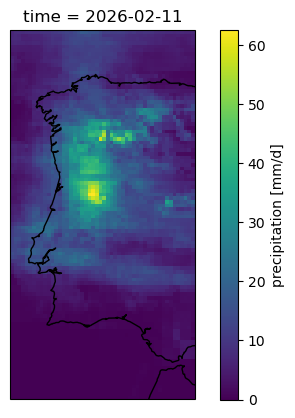

In [3]:
da.isel(time = -1).plot(subplot_kws = {"projection" : mapproj})
plt.gca().coastlines()

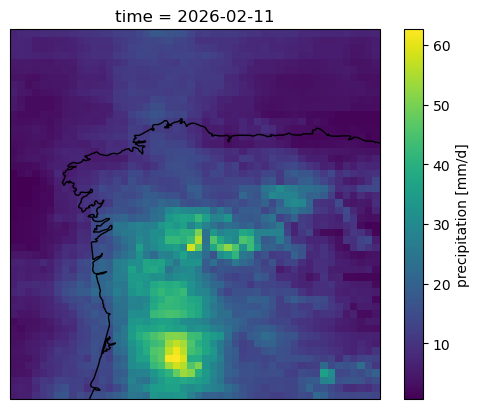

In [4]:
da.isel(time = -1).sel(lat = slice(None, 40)).plot(subplot_kws = {"projection" : mapproj})
plt.gca().coastlines()

In [113]:
rm = regionmask.mask_geopandas(main_polygon(regionmask.defined_regions.natural_earth_v5_1_2.countries_50.to_geodataframe().set_index("abbrevs").loc[["P"]]), da)

In [114]:
# extract time series & save
ts_portugal = da.where(rm == 0).mean(["lat", "lon"])
ts_nportugal = da.where(rm == 0).sel(lat = slice(None, 40)).mean(["lat", "lon"])

ts_portugal.to_netcdf("data/ts_pr_mswep_portugal.nc")
ts_nportugal.to_netcdf("data/ts_pr_mswep_nportugal.nc")

xr.merge([ts_portugal.rename("pr_pt"), ts_nportugal.rename("pr_npt")]).to_dataframe().to_csv("data/ts_pr_mswep_portugal.csv")

## ERA5

In [ ]:
da = xr.open_dataset("data/era5_tp_daily_Portugal.nc").tp.sel(lon = slice(-10,None), lat = slice(None, 37))

In [21]:
ts_portugal = da.mean(["lat", "lon"])
ts_nportugal = da.sel(lat = slice(None, "40")).mean(["lat", "lon"])

In [ ]:
ts_portugal.rename("pr_pt").to_netcdf("data/ts_pr_era5x_portugal.nc")
ts_nportugal.rename("pr_npt").to_netcdf("data/ts_pr_era5x_nportugal.nc")

In [17]:
xr.merge([ts_portugal.rename("pr_pt"), ts_nportugal.rename("pr_npt")]).to_dataframe().to_csv("data/ts_pr_era5x_portugal.csv")

In [50]:
da.isel(time = -1).plot()

ValueError: Dataset.plot cannot be called directly. Use an explicit plot method, e.g. ds.plot.scatter(...)

In [4]:
ts_portugal.sel(time = slice("2025",None)).plot()

NameError: name 'ts_portugal' is not defined

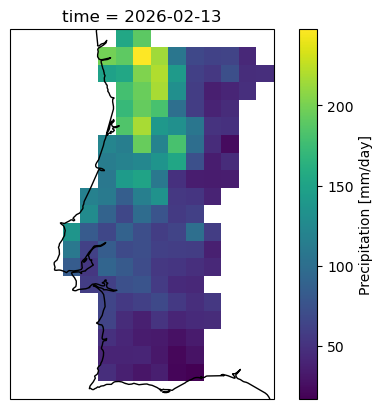

In [ ]:
da.isel(time = -1).plot(subplot_kws = {"projection" : mapproj})
plt.gca().coastlines()

### Convert Mariam time series to .csv

In [3]:
ts1 = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/mediterranean-storms/obs/ERA5_Kris_daily-ts.nc").tp.rename("pr_n")
ts2 = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/mediterranean-storms/obs/ERA5_LeMa_daily-ts.nc").tp.rename("pr_s")

FileNotFoundError: [Errno 2] No such file or directory: '/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/mediterranean-storms/obs/ERA5_Kris_daily-ts.nc'

## Compare time series

In [ ]:
ts_mswx = pd.read_csv("data/ts_pr_mswep_portugal.csv", index_col = "time", parse_dates = ["time"])
ts_era5 = pd.read_csv("data/ts_pr_era5x_portugal.csv", index_col = "time", parse_dates = ["time"])

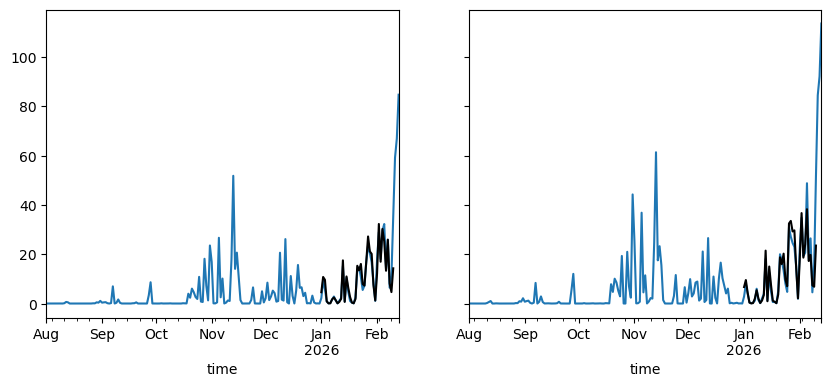

In [116]:
fig, axs = plt.subplots(ncols = 2, figsize = (10,4), dpi = 100, sharex = True, sharey = True)

for i in range(2):
    ax = axs[i]
    rnm = ["pt", "npt"][i]
    ts_era5.loc[slice("2025-08",None), "pr_"+rnm].plot(ax = ax)
    ts_mswx.loc[slice("2025-08",None), "pr_"+rnm].plot(ax = ax, color = "k")

## Timing of annual maximum

In [125]:
ts_era5 = pd.read_csv("data/ts_pr_era5x_portugal.csv", index_col = "time", parse_dates = ["time"]).to_xarray()

In [129]:
daymax = xr.concat([ts_era5.sel(time = str(y)).idxmax().expand_dims(year = [y]) for y in range(1950,2027)], "year")

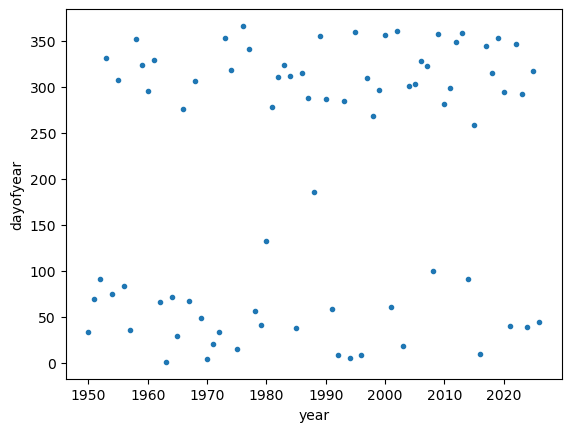

In [134]:
daymax.pr_pt.dt.dayofyear.plot(marker = ".", ls = "")

## Accumulations

In [ ]:
def y_offset(months): return datetime(2020,months,1).timetuple().tm_yday

In [37]:
rnm = "nportugal"
pr = eval("ts_"+rnm)

doy_offset = 0 #y_offset(5)
# pr.rolling(time = 91).sum().dropna("time").to_netcdf("pr-91day_"+rnm+"_era5land.nc")   # data for Tom
pr = pr.assign_coords(offset_time = ("time", [pd.Timestamp(t) + relativedelta(days = doy_offset) for t in pr.time.values])) # shift time for offset axes

days = pd.date_range(start = "2024-01-01", end = "2025-01-01")
# days = [d - relativedelta(days = doy_offset) for d in pd.date_range(start = "2026-01-01", end = "2027-01-01")]
labelticks = [i for i in range(len(days)) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(len(days)) if (days[i].day) == 15]

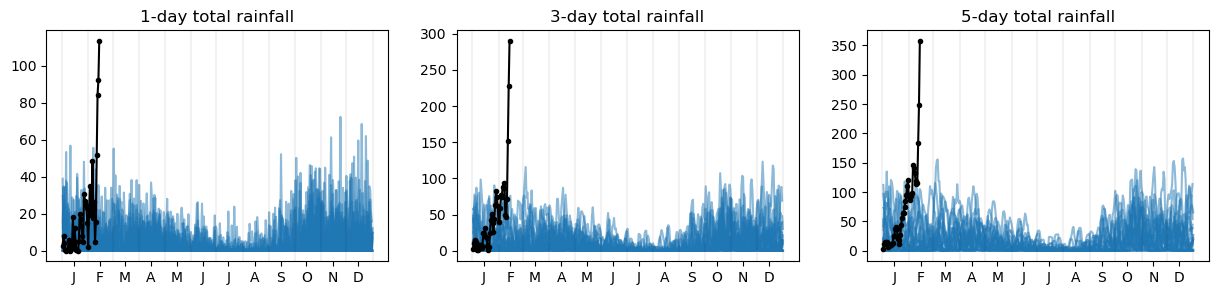

In [41]:
ndays = [1,3,5]

nc = 3; nr = int(np.ceil(len(ndays)/nc))
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*5, nr*3), dpi = 100, sharex = True)

for i in range(len(ndays)):
    ax = axs.flatten()[i]
    nd = ndays[i]

    ts = pr.rolling(time = nd).sum()

    y = 2026; ts_y = ts.sel(time = ts.offset_time.dt.year == y)
    ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "k", label = "2025", zorder = 99, marker = ".")
    
    for y in range(2000,2026):
        ts_y = ts.sel(time = ts.offset_time.dt.year == y)
        ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5, label = "_years")

    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(len(days)) if (days[x].day) == 1]
    ax.set_title(str(nd)+"-day total rainfall")

    # ylim = ax.get_ylim()
    # if rnm == "chile2026":
    #     ax.add_patch(Rectangle((days.get_loc("2026-01-18"), 0), 3, ylim[1]+10, color = "gold", alpha = 0.3))
    # elif rnm == "patagonia":
    #     ax.add_patch(Rectangle((days.get_loc("2026-01-06"), 0), 21, ylim[1]+10, color = "gold", alpha = 0.3))
    # ax.set_ylim(ylim)

# plt.savefig("fig/expl_accumulated-pr_"+rnm+"_.png")